<a href="https://colab.research.google.com/github/NBK-code/MachineTranslation/blob/main/Machine_Translation_using_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural machine translation using RNNs

Here we will build a neural machine translation model using RNNs. In particular we will be using LSTM layers to perform English to German translation. We will use the language dataset from http://www.manythings.org/anki/ to train and test the model. This dataset consists of over 200,000 pairs of sentences in English and German. But we will work with a subset of the data to simplify training.


First, let us import the necessary libraries.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Input, Masking, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import json
import matplotlib.pyplot as plt
from IPython.display import Image

#### Import the data


In [ ]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [ ]:
# Run this cell to load the dataset

NUM_EXAMPLES = 20000
data_examples = []
with open('./gdrive/MyDrive/Colab_Notebooks/Projects/Machine_Translation_with_RNNs/Data/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [ ]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

#### The translation model
The following is the schematic of the model architecture we will be implementing.

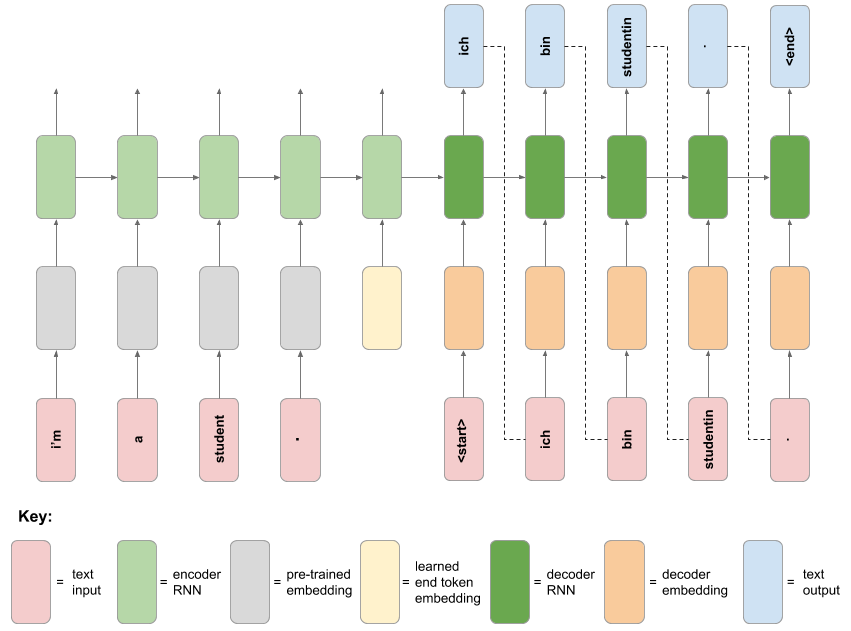

In [ ]:
# Run this cell to view the schematic for the neural translation model


!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1XsS1VlXoaEo-RbYNilJ9jcscNZvsSPmd"
Image("neural_translation_model.png")

The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing


In [ ]:
English_sentences = []
German_sentences = []

In [ ]:
#Separate English and German Sentences and Preprocess 

for i in range(NUM_EXAMPLES):
    English_sentences.append(preprocess_sentence(data_examples[i].split('\t')[0]))
    German_sentences.append(preprocess_sentence(data_examples[i].split('\t')[1]))

In [ ]:
#Add <start> and <end> to German Sentences

for i in range(NUM_EXAMPLES):
    German_sentences[i] = "<start> "+ German_sentences[i] + " <end>"

In [ ]:
#Tokenize the German Sentences

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(German_sentences)
German_sentence_seq = tokenizer.texts_to_sequences(German_sentences)

In [ ]:
tokenizer_config = tokenizer.get_config()

word_counts = json.loads(tokenizer_config['word_counts'])
index_word = json.loads(tokenizer_config['index_word'])
word_index = json.loads(tokenizer_config['word_index'])

In [ ]:
#Print five random English and German Sentences along with the Tokenized Sequences

seed_1 = random.sample(range(0,NUM_EXAMPLES), 5)

for i, idx in enumerate(seed_1):
    print(i+1)
    print("English sentence:", English_sentences[idx])
    print("German sentence:", German_sentences[idx])
    print("Tokenized German sentence:", German_sentence_seq[idx])
    print("\n")

1
English sentence: he's on his way .
German sentence: <start> er ist unterwegs . <end>
Tokenized German sentence: [1, 14, 6, 1972, 3, 2]


2
English sentence: who will do it ?
German sentence: <start> wer wird es machen ? <end>
Tokenized German sentence: [1, 43, 48, 10, 86, 7, 2]


3
English sentence: i'm in a hurry .
German sentence: <start> ich habe es eilig . <end>
Tokenized German sentence: [1, 4, 18, 10, 2709, 3, 2]


4
English sentence: i have a minute .
German sentence: <start> ich habe eine minute . <end>
Tokenized German sentence: [1, 4, 18, 37, 1364, 3, 2]


5
English sentence: wait a moment .
German sentence: <start> wartet mal kurz . <end>
Tokenized German sentence: [1, 615, 76, 388, 3, 2]




In [ ]:
#Pad the German Sentence Sequences

padded_German_seqs = pad_sequences(German_sentence_seq, padding = 'post', value = 0.0)

## 2. Prepare the data

#### Load the embedding layer
As part of preproceessing, we will use a pre-trained English word embedding module from TensorFlow Hub. The module is available at https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1.

This embedding takes a batch of text tokens in a 1-D tensor of strings as input. It then embeds the separate tokens into a 128-dimensional space.

In [ ]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [ ]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

In [ ]:
#Split the Data into Train, Validation and Test.
#We will do this in the ratio (0.72, 0.18, 0.10)

train_inputs, test_inputs, train_targets, test_targets = train_test_split(English_sentences, 
                                                                          padded_German_seqs, 
                                                                          test_size=0.1)

train_inputs, val_inputs, train_targets, val_targets = train_test_split(train_inputs, 
                                                                        train_targets,
                                                                        test_size=0.2)

In [ ]:
#Prepare Train and Validation datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_targets))
val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, val_targets))

In [ ]:
#Function to Split English Sentences at Spaces

def Split_English_Sentences(English_sentence, German_sequence):
    return tf.strings.split(English_sentence, sep = ' '), German_sequence

#Split English Sentences at Spaces

train_dataset = train_dataset.map(Split_English_Sentences)
val_dataset = val_dataset.map(Split_English_Sentences)

In [ ]:
#Function to Embed English Sentences

def embed_English_words(English_sentence, German_sequence):
    return embedding_layer(English_sentence), German_sequence

#Embed English Sentences

train_dataset = train_dataset.map(embed_English_words)
val_dataset = val_dataset.map(embed_English_words)

In [ ]:
#We will work with only those English sentences which are of length less than or equal to 13

#Function to Filter English Sentences of Length Greater than 13

def filter_English_sentences(English_embed_sequence, German_sequence):
    return tf.shape(English_embed_sequence)[0] <= 13

#Filter English Sentences of Length Greater than 13

train_dataset = train_dataset.filter(filter_English_sentences)
val_dataset = val_dataset.filter(filter_English_sentences)

In [ ]:
#Function to Pad English Sentences

def pad_English_sequences(English_embed_sequence, German_sequence):
    l = (13 - int(tf.shape(English_embed_sequence)[0]))
    paddings = [[l, 0], [0, 0]]
    padded_English_sequence = tf.pad(English_embed_sequence, paddings)
    return padded_English_sequence, German_sequence

#Pad English Sentences

train_dataset = train_dataset.map(pad_English_sequences)
val_dataset = val_dataset.map(pad_English_sequences)

In [ ]:
#Batch the Train and Validation Dataset

train_dataset = train_dataset.batch(16)
val_dataset = val_dataset.batch(16)

In [ ]:
#Train and Validation Dataset Element Spec

print(train_dataset.element_spec)
print(val_dataset.element_spec)

(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))


## 3. Create the Encoder layer
We will now build a custom layer using layer subclassing that takes a batch of English data examples from one of the Datasets, and adds a learned embedded ‘end’ token to the end of each sequence. 

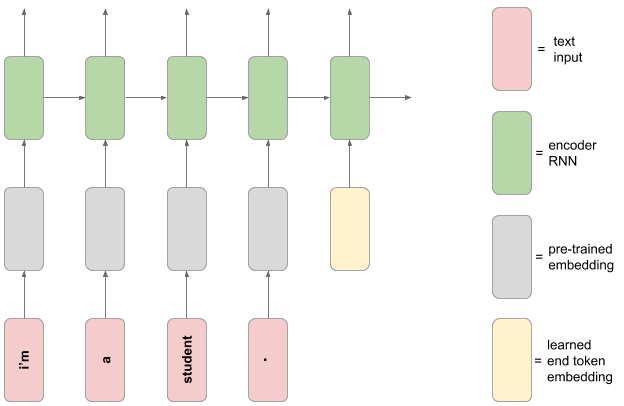

In [ ]:
# Run this cell to download and view a schematic diagram for the encoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1JrtNOzUJDaOWrK4C-xv-4wUuZaI12sQI"
Image("neural_translation_model.png")

In [ ]:
#Custom Layer to Include a Trainable End Token in English Sentences

class English_End_Token(Layer):
    
    def __init__(self, **kwargs):
        super(English_End_Token, self).__init__(**kwargs)
        self.end = tf.Variable(initial_value = tf.zeros(shape = (1,128)), 
                               trainable = True, 
                               dtype = tf.float32)
        
    def call(self, inputs):
        v1 = self.end
        v1 = tf.tile(v1, [tf.shape(inputs)[0], 1])
        v1 = tf.expand_dims(v1, axis = 1)
        return tf.concat([inputs, v1], axis = 1)

In [ ]:
#Get an Instance of the Custom Layer

English_End_Token_Layer = English_End_Token()

In [ ]:
#Input and Output Shapes of the Custom Layer

for element in train_dataset.take(1):
    English_data, German_data = element
    print("Shape of the input batch before adding end token:", English_data.shape)
    print("Shape of the input batch after adding end token:", English_End_Token_Layer(English_data).shape)

Shape of the input batch before adding end token: (16, 13, 128)
Shape of the input batch after adding end token: (16, 14, 128)


## 4. Build the encoder network


In [ ]:
#Build Encoder Network

def encoder_network(input_shape):
    
    #Encodes the English data
    
    inputs = Input(shape = input_shape)
    h = English_End_Token_Layer(inputs)
    h = Masking(mask_value = 0.0)(h)
    whole_seq_output, final_hidden_state, final_cell_state = LSTM(units = 512, 
                                                                   return_sequences = True, 
                                                                   return_state = True)(h)
    
    encoder_model = Model(inputs = inputs, 
                          outputs = [final_hidden_state, final_cell_state])
    
    return encoder_model

In [ ]:
#Get an Instance of the Encoder Network

encoder_model = encoder_network((13, 128))

In [ ]:
#Input and Output Shapes of the Encoder Network

for element in train_dataset.take(1):
    English_data, German_data = element
    print("Shape of the input batch:", English_data.shape)
    print("Shape of the output hidden state:", encoder_model(English_data)[0].shape)

Shape of the input batch: (16, 13, 128)
Shape of the output hidden state: (16, 512)


In [ ]:
#Encoder Model Summary

encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 13, 128)]         0         
_________________________________________________________________
english__end__token_1 (Engli (None, 14, 128)           128       
_________________________________________________________________
masking_1 (Masking)          (None, 14, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                [(None, 14, 512), (None,  1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


## 5. Build the decoder network
The decoder network follows the schematic diagram below. 

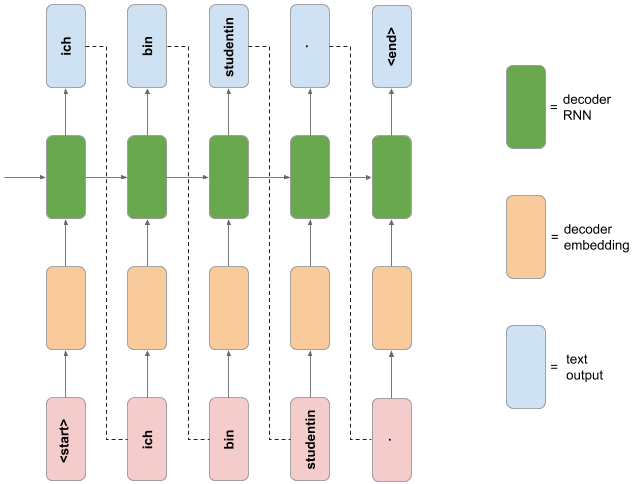

In [ ]:
# Run this cell to download and view a schematic diagram for the decoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1DTeaXD8tA8RjkpVrB2mr9csSBOY4LQiW"
Image("neural_translation_model.png")

We will now build the RNN decoder model.


In [ ]:
#Build Decoder Network

class RNN_decoder_network(Model):
    
    def __init__(self, no_German_tokens, **kwargs):
        super(RNN_decoder_network, self).__init__(**kwargs)
        self.embedding = Embedding(no_German_tokens+1, 128, mask_zero = True)
        self.lstm = LSTM(units = 512, 
                         return_sequences = True, 
                         return_state = True)
        self.dense = Dense(no_German_tokens+1)
        
    def call(self, inputs, hidden_st = None, cell_st = None):
        h = self.embedding(inputs)
        h, out_hidden_state, out_cell_state  = self.lstm(h, initial_state = [hidden_st, 
                                                                             cell_st])
        return self.dense(h), out_hidden_state, out_cell_state
         

In [ ]:
#Get an Instance of the Decoder Network

decoder_model = RNN_decoder_network(len(word_index))

In [ ]:
#Input and Output Shapes of the Decoder Network

for element in train_dataset.take(1):
    English_data, German_data = element
    print("Shape of the input English batch:", English_data.shape)
    print("Shape of the input German batch:", German_data.shape)
    hidden_state, cell_state = encoder_model(English_data)
    print("Shape of the encoder model hindden state:", hidden_state.shape)
    print("Shape of the encoder model cell state:", cell_state.shape)
    out_German, out_hidden_state, out_cell_state = decoder_model(German_data, 
                                                                 hidden_state, 
                                                                 cell_state)
    print("Shape of the output German batch:", out_German.shape)
    print("Shape of the output hidden state:", out_hidden_state.shape)
    print("Shape of the output cell state:", out_cell_state.shape)

Shape of the input English batch: (16, 13, 128)
Shape of the input German batch: (16, 14)
Shape of the encoder model hindden state: (16, 512)
Shape of the encoder model cell state: (16, 512)
Shape of the output German batch: (16, 14, 5744)
Shape of the output hidden state: (16, 512)
Shape of the output cell state: (16, 512)


In [ ]:
#Decoder Model Summary

decoder_model.summary()

Model: "rnn_decoder_network_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  735232    
_________________________________________________________________
lstm_3 (LSTM)                multiple                  1312768   
_________________________________________________________________
dense_1 (Dense)              multiple                  2946672   
Total params: 4,994,672
Trainable params: 4,994,672
Non-trainable params: 0
_________________________________________________________________


## 6. Make a custom training loop


In [ ]:
def German_inputs_outputs(German_batch_data):
    initial = 1
    final = German_batch_data.shape[1]-1
    German_inputs = German_batch_data[:, :final]
    German_outputs = German_batch_data[:, initial:]
    return German_inputs, German_outputs

In [ ]:
# Create the optimizer and loss

optimizer_obj = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
@tf.function
def model_forward_backward_pass(encoder_model, 
                                decoder_model, 
                                English_input, 
                                German_input, 
                                German_output, 
                                loss):
    
    with tf.GradientTape() as tape:
        encoder_hidden_state, encoder_cell_state = encoder_model(English_input)
        decoder_German_output, _, _ = decoder_model(German_input,
                                                    encoder_hidden_state,
                                                    encoder_cell_state)
        loss_value = loss(German_output, decoder_German_output)
        gradients = tape.gradient(loss_value, 
                                  encoder_model.trainable_variables+ 
                                   decoder_model.trainable_variables)
    
    return loss_value, gradients
    

In [ ]:
# Run the custom training loop

num_epochs = 25


train_loss_results = []
val_loss_results = []


for epoch in range(num_epochs):
    
    train_epoch_loss_avg = tf.keras.metrics.Mean()
    val_epoch_loss_avg = tf.keras.metrics.Mean()
    

    for element in train_dataset:
        English_data, German_data = element
        German_inputs, German_outputs = German_inputs_outputs(German_data)
        loss_value, gradients = model_forward_backward_pass(encoder_model, 
                                decoder_model, 
                                English_data, 
                                German_inputs, 
                                German_outputs, 
                                loss_obj)
        optimizer_obj.apply_gradients(zip(gradients, 
                                          encoder_model.trainable_variables+ 
                                           decoder_model.trainable_variables))
        
        train_epoch_loss_avg(loss_value)
        
    for element in val_dataset:
        English_data, German_data = element
        German_inputs, German_outputs = German_inputs_outputs(German_data)
        encoder_hidden_state, encoder_cell_state = encoder_model(English_data)
        decoder_German_output, _, _ = decoder_model(German_inputs,
                                                    encoder_hidden_state,
                                                    encoder_cell_state)
        val_loss = loss_obj(German_outputs, decoder_German_output)
        
        val_epoch_loss_avg(val_loss)
        
    train_loss_results.append(train_epoch_loss_avg.result().numpy())
    
    val_loss_results.append(val_epoch_loss_avg.result().numpy())

    print("Epoch {:03d}: Training loss: {:.3f}: Validation loss: {:.3f}".format(epoch, 
                                                                                train_epoch_loss_avg.result(),
                                                                                val_epoch_loss_avg.result()))
    

Epoch 000: Training loss: 4.114: Validation loss: 3.329
Epoch 001: Training loss: 3.145: Validation loss: 2.959
Epoch 002: Training loss: 2.819: Validation loss: 2.659
Epoch 003: Training loss: 2.581: Validation loss: 2.505
Epoch 004: Training loss: 2.423: Validation loss: 2.344
Epoch 005: Training loss: 2.338: Validation loss: 2.340
Epoch 006: Training loss: 2.253: Validation loss: 2.199
Epoch 007: Training loss: 2.214: Validation loss: 2.221
Epoch 008: Training loss: 2.135: Validation loss: 2.094
Epoch 009: Training loss: 2.040: Validation loss: 2.042
Epoch 010: Training loss: 2.024: Validation loss: 2.016
Epoch 011: Training loss: 2.022: Validation loss: 2.043
Epoch 012: Training loss: 1.947: Validation loss: 1.981
Epoch 013: Training loss: 1.929: Validation loss: 1.985
Epoch 014: Training loss: 2.035: Validation loss: 2.028
Epoch 015: Training loss: 1.897: Validation loss: 1.930
Epoch 016: Training loss: 1.891: Validation loss: 1.972
Epoch 017: Training loss: 1.864: Validation loss

In [ ]:
train_loss = []
val_loss = []

In [ ]:
for item in train_loss_results:
    train_loss.append(item)


for item in val_loss_results:
    val_loss.append(item)


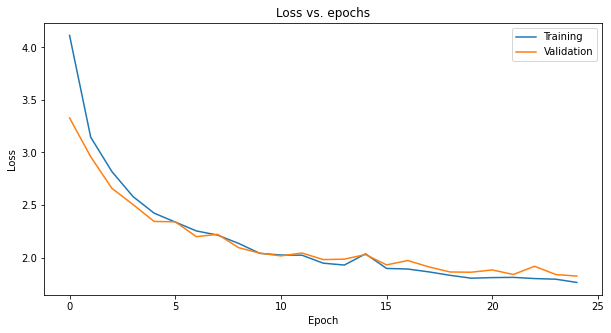

In [ ]:
#Plot Loss vs Epochs

fig = plt.figure(figsize=(10,5))

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## 7. Use the model to translate


We will use greedy decoding to get the German translation.

In [ ]:
#Select 5 Random English Sentences from the Test Set

seed_2 = random.sample(range(0,len(test_inputs)), 5)


In [ ]:
#Preprocess English Sentence

def preprocess_English_sentence(sample_English_sentence):

  #Split by space
  sample_English_sentence,_ = Split_English_Sentences(sample_English_sentence, None)

  #Embed
  sample_English_sentence,_ = embed_English_words(sample_English_sentence, None)

  #Eliminate sentences of length > 13
  if tf.shape(sample_English_sentence)[0] > 13:
    return None

  #Pad to the length 13
  sample_English_sentence,_ = pad_English_sequences(sample_English_sentence, None)

  #Add batch dimension of 1
  sample_English_sentence = tf.expand_dims(sample_English_sentence, axis = 0)

  return sample_English_sentence


In [ ]:
for index, element in enumerate(seed_2):

  print(index+1)
  print("The input English sentence is:", test_inputs[element])
  print(" ")

  English_data = preprocess_English_sentence(test_inputs[element])

  if English_data != None:

    #Pass the processed English data into the encoder model
    encoder_hidden_state, encoder_cell_state = encoder_model(English_data)

    German_data = tf.expand_dims(word_index["<start>"], axis =0)
    German_data = tf.reshape(German_data, (1,1))
    hidden_state = encoder_hidden_state
    cell_state = encoder_cell_state

    German_seq = []
    end_seq = False

    #Loop the decoder model to collect the German output word by word
    while len(German_seq) <= 14 or end_seq == False:
      German_dense_output, hidden_state, cell_state = decoder_model(German_data, hidden_state, cell_state)
      German_data = tf.math.argmax(German_dense_output, axis=2)
      German_seq.append(tf.squeeze(German_data).numpy())
      if tf.squeeze(German_data).numpy() == 2:
        end_seq = True

    print("German translation by our model:", end = " ")
    for item in German_seq:
      if item != 0 and item != 2:
        print(index_word[str(item)], end = " ")   
    print("\n")

    print("The expected German translation:", end = " ")
    for item in test_targets[element]:
      if item !=0 and item != 2 and item != 1:
        print(index_word[str(item)], end = " ")
    print("\n")
    print("\n")    

  else:
    print("This sentence has a length greater than 13. So moving on to the next sentence")  



1
The input English sentence is: i'll come home .
 
German translation by our model: ich werde werde bekommen . 

The expected German translation: ich werde nach hause kommen . 



2
The input English sentence is: shall we begin ?
 
German translation by our model: ist sind sie ? 

The expected German translation: sollen wir anfangen ? 



3
The input English sentence is: do you live here ?
 
German translation by our model: hier ist das ? 

The expected German translation: wohnst du hier ? 



4
The input English sentence is: we depend on you .
 
German translation by our model: sind sie sind . 

The expected German translation: wir sind auf euch angewiesen . 



5
The input English sentence is: what did they do ?
 
German translation by our model: was sie haben ? 

The expected German translation: was haben sie gemacht ? 





It is possible to better the model performance by adding more LSTM layers in the encoder and decoder blocks. But for such a model, the training time increases dramatically.